In [1]:
# -*- coding: utf-8 -*-
"""
Tabu Search pour l'ordonnancement multi-compétences (6 médecins) avec opérations séquentielles par patient.
Chaque opération peut requérir 1..3 compétences, durée 1 ou 2 (contigu, non préemptif).
On cherche à minimiser le makespan.
Représentation : ordres (séquences) par (skill s, étape/opération k).
Le planning est calculé "par étapes" (k=1..5) pour respecter l'ordre des opérations.
"""

from copy import deepcopy
import random
from collections import defaultdict, namedtuple

random.seed(42)

# ---------------------------
# 1) Données de la table
# ---------------------------

# skills 1..6
SKILLS = [1, 2, 3, 4, 5, 6]
NUM_PATIENTS = 10
MAX_OPS = 5  # au plus 5 opérations

# Encodage : pour chaque patient i (1..10), et pour chaque opération j (1..5),
# on fournit une liste de tuples (skill, duration)
# NB: si "aucune opération", mettre []
DATA = {
    1: {
        1: [(1,2)],
        2: [(1,1),(2,1)],
        3: [(1,1),(3,1)],
        4: [(1,1),(2,2)],  # C1 et C2x2
        5: [(4,1),(5,2),(6,1)],
    },
    2: {
        1: [(2,1),(3,1)],
        2: [(2,1),(3,1)],
        3: [(2,1)],
        4: [],
        5: [],
    },
    3: {
        1: [(3,2)],
        2: [(3,1)],
        3: [],
        4: [],
        5: [],
    },
    4: {
        1: [(4,2)],
        2: [(5,1),(6,1)],
        3: [(6,2)],
        4: [(4,2)],
        5: [(1,1),(2,1)],
    },
    5: {
        1: [(2,2)],
        2: [(5,1)],
        3: [(5,1),(6,1)],
        4: [(4,1),(5,1)],
        5: [(3,1)],
    },
    6: {
        1: [(1,1)],
        2: [(4,1)],
        3: [(6,1)],
        4: [],
        5: [],
    },
    7: {
        1: [(6,2)],
        2: [(1,1)],
        3: [(5,1),(6,1)],
        4: [(3,1)],
        5: [],
    },
    8: {
        1: [(3,1),(5,1)],
        2: [(2,1),(5,1)],
        3: [(3,1),(6,1)],
        4: [(6,1)],
        5: [],
    },
    9: {
        1: [(5,1)],
        2: [(4,1)],
        3: [(1,1)],
        4: [],
        5: [],
    },
    10: {
        1: [(4,1)],
        2: [(4,1),(5,1)],
        3: [(1,1),(2,1)],
        4: [(4,1)],
        5: [],
    },
}

# ---------------------------
# 2) Construction des "tâches" élémentaires
#    Une tâche = (patient i, op j, skill s, dur p)
# ---------------------------

Task = namedtuple("Task", ["i", "j", "s", "p"])

ALL_TASKS = []  # liste de toutes les tâches
TASKS_BY_SKILL_STAGE = defaultdict(list)  # (s, j) -> liste des tâches (ordre à optimiser)
PATIENT_LAST_STAGE = {i: 0 for i in range(1, NUM_PATIENTS+1)}

for i in range(1, NUM_PATIENTS+1):
    for j in range(1, MAX_OPS+1):
        ops = DATA[i].get(j, [])
        if ops:
            PATIENT_LAST_STAGE[i] = j
        for (s, p) in ops:
            t = Task(i=i, j=j, s=s, p=p)
            ALL_TASKS.append(t)
            TASKS_BY_SKILL_STAGE[(s, j)].append(t)

# ---------------------------
# 3) Solution initiale
#    Par défaut : dans chaque (s, j), ordre croissant des patients
#    (Tu peux surcharger avec l'ordre de ta figure ci-dessous)
# ---------------------------

# Format de surcharge :
# INITIAL_ORDER_OVERRIDE[(skill, stage)] = [patient_ids dans l'ordre voulu]
# (seuls les patients ayant une tâche (s, j) seront pris en compte)
INITIAL_ORDER_OVERRIDE = {
    # Exemple : (2,1): [5,2,8,1,7,...]
    # Laisse vide si tu veux l'ordre naïf (1..10).
}

def build_initial_sequences():
    seq = {}
    for s in SKILLS:
        for j in range(1, MAX_OPS+1):
            tasks = TASKS_BY_SKILL_STAGE.get((s, j), [])
            if not tasks:
                continue
            # Ordre naïf = patients croissants
            default_order = sorted(tasks, key=lambda t: (t.i))
            # Surcharge éventuelle
            if (s, j) in INITIAL_ORDER_OVERRIDE:
                allowed = set(t.i for t in tasks)
                order_patients = [i for i in INITIAL_ORDER_OVERRIDE[(s, j)] if i in allowed]
                # compléter avec ceux non listés, dans l'ordre naïf
                remaining = [t.i for t in default_order if t.i not in order_patients]
                final_order_patients = order_patients + remaining
                # reconstruire la liste de tâches dans cet ordre
                patient_to_tasks = defaultdict(list)
                for t in tasks:
                    patient_to_tasks[t.i].append(t)
                # (il n'y a qu'une tâche par (i,s,j) ici, donc c'est direct)
                ordered_tasks = [patient_to_tasks[i][0] for i in final_order_patients]
            else:
                ordered_tasks = default_order
            seq[(s, j)] = ordered_tasks
    return seq

# ---------------------------
# 4) Evaluation (construction du planning "par étapes")
# ---------------------------

from itertools import permutations
from collections import defaultdict
import math

def evaluate_schedule(sequences, return_schedule=False):
    """
    Nouvelle évaluation qui impose :
      - pour chaque opération (i,j) multi-compétences, les sous-tâches forment
        un bloc contigu : soit simultané, soit successif sans trou.
    On construit le planning par étapes j=1..5. Pour l'ordre intra-étape,
    on utilise une priorité dérivée des séquences (moyenne des rangs par compétence requise).
    """
    # disponibilités des ressources (compétences)
    res_free = {s: 0 for s in SKILLS}
    # fin d'étape j pour chaque patient
    op_completion = {(i, 0): 0 for i in range(1, NUM_PATIENTS + 1)}
    # stockage des horaires par sous-tâche (i,j,s) -> (start, end, p)
    task_times = {}

    # Pré-calcul des rangs (position) dans chaque séquence (s,j)
    rank = {}
    for (s, j), lst in sequences.items():
        for pos, t in enumerate(lst):
            rank[(s, j, t.i)] = pos  # position du patient t.i dans la file (s,j)

    def op_priority(i, j):
        """Priorité d'une opération (i,j) = moyenne des positions du patient i
        dans les séquences des compétences requises pour j (plus petit = plus prioritaire)."""
        skills = [s for (s, p) in DATA[i].get(j, [])]
        if not skills:
            return math.inf
        positions = []
        for s in skills:
            positions.append(rank.get((s, j, i), 1e6))  # si absent, grand rang
        return sum(positions) / len(positions)

    # Parcours des étapes
    for j in range(1, MAX_OPS + 1):

        # Liste des patients ayant une opération j, triés par priorité
        patients_j = [i for i in range(1, NUM_PATIENTS + 1) if DATA[i].get(j, [])]
        patients_j.sort(key=lambda i: op_priority(i, j))

        for i in patients_j:
            # Compétences et durées requises pour l'opération (i,j)
            items = DATA[i][j]  # liste de (s, p)
            skills = [s for (s, p) in items]
            durs = {s: p for (s, p) in items}
            ready = op_completion[(i, j - 1)]  # fin de l'étape précédente

            # ----- Option 1 : simultané -----
            # Le bloc démarre à t = max(ready, max(res_free[s])) et dure max(p_s)
            t_simul = max([ready] + [res_free[s] for s in skills])
            finish_simul = t_simul + max(durs.values())
            plan_simul = {s: (t_simul, t_simul + durs[s]) for s in skills}

            # ----- Option 2 : successif (dos-à-dos) -----
            # On teste toutes les permutations des compétences (<= 3! = 6)
            best_successive = None  # (finish_time, plan_dict, order, start)
            for order in permutations(skills, len(skills)):
                # On cherche le plus petit t >= ready tel que :
                #   res_free[s_k] <= t + sum_{m<k} p_{s_m}  pour tout k
                offsets = []
                cum = 0
                t_candidate = ready
                for idx, s in enumerate(order):
                    t_candidate = max(t_candidate, res_free[s] - cum)
                    cum += durs[s]
                # t_candidate est le plus tôt possible pour cette permutation
                start = t_candidate
                cum = 0
                plan = {}
                for s in order:
                    st = start + cum
                    en = st + durs[s]
                    plan[s] = (st, en)
                    cum += durs[s]
                finish = start + sum(durs.values())
                if (best_successive is None) or (finish < best_successive[0]):
                    best_successive = (finish, plan, order, start)

            # Choix de la meilleure des deux options
            if best_successive[0] <= finish_simul:
                finish, plan, order, start_blk = best_successive
            else:
                finish, plan, order, start_blk = finish_simul, plan_simul, None, t_simul

            # Enregistrement des horaires et mise à jour des ressources
            for s in skills:
                st, en = plan[s]
                task_times[(i, j, s)] = (st, en, durs[s])
                res_free[s] = en  # ressource s sera libre à la fin de sa sous-tâche

            # Fin d'étape j pour le patient i = fin du bloc (max des fins des sous-tâches)
            op_completion[(i, j)] = max(en for (_, en) in plan.values())

        # Pour les patients sans opération j, on propage la fin d'étape
        for i in range(1, NUM_PATIENTS + 1):
            if not DATA[i].get(j, []):
                op_completion[(i, j)] = op_completion[(i, j - 1)]

    # Makespan = max fin de dernière étape utile par patient
    makespan = 0
    for i in range(1, NUM_PATIENTS + 1):
        last_j = PATIENT_LAST_STAGE[i]
        makespan = max(makespan, op_completion[(i, last_j)])

    if return_schedule:
        return makespan, task_times, op_completion
    return makespan

# ---------------------------
# 5) Voisinage (swaps adjacents par (s,j))
# ---------------------------

def generate_neighbors(sequences):
    """
    Génère des voisins par échange adjacent dans chaque (s, j)
    Retourne une liste de tuples (move, new_sequences)
    où move = (s, j, pos) signifiant swap entre pos et pos+1.
    """
    neighbors = []
    for (s, j), lst in sequences.items():
        n = len(lst)
        if n <= 1:
            continue
        for pos in range(n - 1):
            new_seq = deepcopy(sequences)
            a = new_seq[(s, j)][pos]
            b = new_seq[(s, j)][pos+1]
            new_seq[(s, j)][pos], new_seq[(s, j)][pos+1] = b, a
            move = (s, j, pos, a.i, b.i)  # on mémorise aussi les patients échangés (utile pour Tabu)
            neighbors.append((move, new_seq))
    return neighbors

# ---------------------------
# 6) Tabu Search
# ---------------------------

def tabu_search(
    initial_seq,
    max_iter=200,
    tabu_tenure=10,
    candidate_limit=200,   # on peut limiter le nb de voisins évalués par itération
    verbose=True
):
    current = deepcopy(initial_seq)
    best = deepcopy(initial_seq)
    best_cost = evaluate_schedule(best)
    current_cost = best_cost

    # liste tabou: enregistre les "moves" récents (s,j,pos,patientA,patientB)
    tabu_list = []

    if verbose:
        print(f"[Init] Makespan = {best_cost}")

    for it in range(1, max_iter+1):
        # génère voisins
        neighbors = generate_neighbors(current)
        # échantillonnage si besoin
        if len(neighbors) > candidate_limit:
            neighbors = random.sample(neighbors, candidate_limit)

        # choisir le meilleur voisin autorisé (aspiration si améliore le best global)
        best_neighbor_cost = None
        best_neighbor = None
        best_move = None

        for move, seq in neighbors:
            is_tabu = move in tabu_list
            cost = evaluate_schedule(seq)
            if (not is_tabu) or (cost < best_cost):  # aspiration si mieux que best global
                if (best_neighbor_cost is None) or (cost < best_neighbor_cost):
                    best_neighbor_cost = cost
                    best_neighbor = seq
                    best_move = move

        # si aucun voisin admissible (situation rare), on saute (ou on brise la tabu la + ancienne)
        if best_neighbor is None:
            # relâche un tabu (diversification)
            if tabu_list:
                tabu_list.pop(0)
            continue

        # on se déplace
        current = best_neighbor
        current_cost = best_neighbor_cost

        # met à jour best global
        if current_cost < best_cost:
            best = deepcopy(current)
            best_cost = current_cost

        # mettre le move en Tabu
        tabu_list.append(best_move)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        if verbose and (it % 10 == 0 or current_cost <= best_cost):
            print(f"[It {it:3d}] current={current_cost}  best={best_cost}  (move={best_move})")

    return best, best_cost

# ---------------------------
# 7) Lancement
# ---------------------------

if __name__ == "__main__":
    init_seq = build_initial_sequences()
    best_seq, best_cost = tabu_search(
        init_seq,
        max_iter=250,
        tabu_tenure=15,
        candidate_limit=300,
        verbose=True
    )
    print("\n=== Résultat Tabu ===")
    print(f"Meilleur makespan : {best_cost}")

    # Affichage d'un petit résumé du planning final
    mk, task_times, op_completion = evaluate_schedule(best_seq, return_schedule=True)
    print("\nFin des étapes par patient (dernier j non vide) :")
    for i in range(1, NUM_PATIENTS+1):
        last_j = PATIENT_LAST_STAGE[i]
        print(f"Patient {i}: fin étape {last_j} = {op_completion[(i,last_j)]}")

    print("\nSéquences finales (par skill, par étape) :")
    for s in SKILLS:
        for j in range(1, MAX_OPS+1):
            tasks = best_seq.get((s,j), [])
            if not tasks:
                continue
            order = [(t.i, t.j, t.p) for t in tasks]
            print(f"Skill {s}, Etape {j}: {order}")

    # Exemple: récupérer les temps d'une tâche précise
    # print(task_times[(1, 4, 2)])  # (start, finish, duration) pour patient 1, étape 4, skill 2

[Init] Makespan = 14
[It   1] current=12  best=12  (move=(3, 1, 1, 3, 8))
[It   2] current=12  best=12  (move=(1, 1, 0, 1, 6))
[It   3] current=12  best=12  (move=(1, 1, 0, 6, 1))
[It   4] current=12  best=12  (move=(1, 2, 0, 1, 7))
[It   5] current=12  best=12  (move=(1, 2, 0, 7, 1))
[It   6] current=12  best=12  (move=(1, 3, 0, 1, 9))
[It   7] current=12  best=12  (move=(1, 3, 0, 9, 1))
[It   8] current=12  best=12  (move=(1, 3, 1, 9, 10))
[It   9] current=12  best=12  (move=(1, 3, 0, 1, 10))
[It  10] current=12  best=12  (move=(1, 3, 0, 10, 1))
[It  11] current=12  best=12  (move=(1, 3, 1, 10, 9))
[It  12] current=12  best=12  (move=(2, 2, 0, 1, 2))
[It  13] current=12  best=12  (move=(2, 2, 0, 2, 1))
[It  14] current=12  best=12  (move=(2, 2, 1, 2, 8))
[It  15] current=12  best=12  (move=(2, 2, 0, 1, 8))
[It  16] current=12  best=12  (move=(2, 2, 0, 8, 1))
[It  17] current=12  best=12  (move=(2, 2, 1, 8, 2))
[It  18] current=12  best=12  (move=(1, 1, 0, 1, 6))
[It  19] current=12  

Makespan = 12


/var/folders/jb/_8hdb8md6v5bnfkqkrpwrgth0000gn/T/ipykernel_60530/4141985471.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("tab20", n)


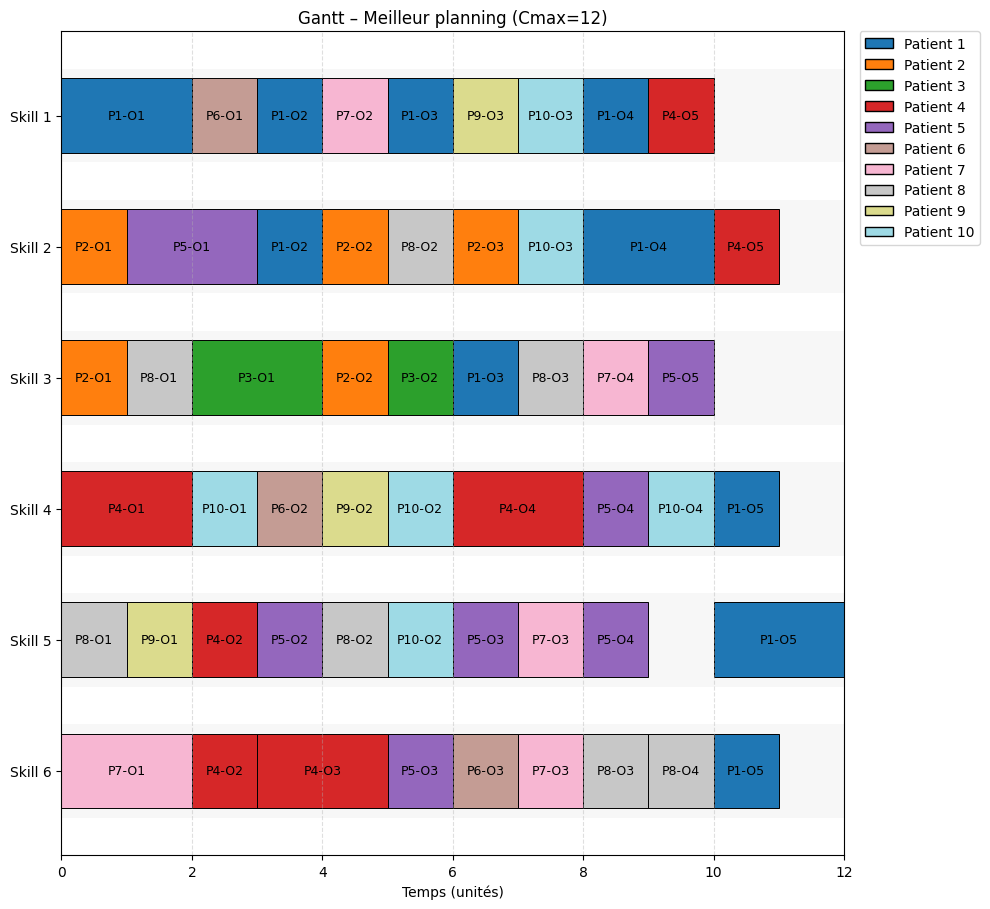

In [3]:
# =========================================
# 8) Visualisation du Gantt (matplotlib)
# =========================================
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
import math

def _patient_colors(n=10):
    """Palette stable pour 10 patients (tab20)."""
    import matplotlib
    cmap = matplotlib.cm.get_cmap("tab20", n)
    return {i+1: cmap(i) for i in range(n)}

def build_gantt_data(task_times):
    """
    Re-formate task_times -> dict skill -> liste d'items triés
    item = dict(start, end, dur, patient, op)
    """
    by_skill = {s: [] for s in SKILLS}
    horizon = 0
    for (i, j, s), (start, finish, p) in task_times.items():
        by_skill[s].append({
            "start": start, "end": finish, "dur": p,
            "patient": i, "op": j
        })
        horizon = max(horizon, finish)
    # trier par début
    for s in SKILLS:
        by_skill[s].sort(key=lambda x: (x["start"], x["patient"], x["op"]))
    return by_skill, horizon

def plot_gantt(task_times, title="Gantt – Planning par compétence",
               figsize=None, annotate=True, save_path=None, dpi=150):
    """
    task_times : dict (i,j,s) -> (start, end, dur) renvoyé par evaluate_schedule(..., return_schedule=True)
    - Une piste (ligne) par compétence s ∈ {1..6}
    - Couleurs par patient
    """
    by_skill, horizon = build_gantt_data(task_times)
    colors = _patient_colors(n=10)

    if figsize is None:
        # largeur ~ horizon, hauteur ~ nb skills
        figsize = (max(10, horizon * 0.6), 1.2 * len(SKILLS) + 2)

    fig, ax = plt.subplots(figsize=figsize)

    lane_height = 0.8
    y_gap = 0.6
    # pour placer la lane s à y = idx
    y_positions = {s: (len(SKILLS)-idx-1)*(lane_height + y_gap) for idx, s in enumerate(SKILLS)}
    ymin = -0.5
    ymax = max(y_positions.values()) + lane_height + 0.5

    # Dessin des rectangles
    for s in SKILLS:
        y = y_positions[s]
        # bande de fond par piste
        ax.add_patch(Rectangle((0, y - 0.1), horizon, lane_height + 0.2,
                               facecolor=(0,0,0,0.03), edgecolor="none"))
        for it in by_skill[s]:
            start = it["start"]
            dur   = it["dur"]
            end   = it["end"]
            i     = it["patient"]
            j     = it["op"]
            rect = Rectangle((start, y), dur, lane_height,
                             facecolor=colors[i], edgecolor="black", linewidth=0.7)
            ax.add_patch(rect)
            if annotate:
                label = f"P{i}-O{j}"
                ax.text(start + dur/2, y + lane_height/2, label,
                        ha="center", va="center", fontsize=9)

    # Axes / ticks / labels
    ax.set_xlim(0, math.ceil(horizon))
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Temps (unités)")
    ax.set_yticks([y_positions[s] + lane_height/2 for s in SKILLS])
    ax.set_yticklabels([f"Skill {s}" for s in SKILLS])
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    # Légende des patients
    legend_handles = [Patch(facecolor=colors[i], edgecolor="black", label=f"Patient {i}") for i in range(1, 11)]
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"Gantt sauvegardé : {save_path}")
    plt.show()

# =========================================
# Exemple d'utilisation après la Tabu Search
# =========================================
if __name__ == "__main__":
    # ... après :
    # best_seq, best_cost = tabu_search(...)
    mk, task_times, op_completion = evaluate_schedule(best_seq, return_schedule=True)

    print(f"Makespan = {mk}")
    plot_gantt(task_times, title=f"Gantt – Meilleur planning (Cmax={mk})",
               figsize=None, annotate=True, save_path=None)
    # Pour sauvegarder au lieu d'afficher :
    # plot_gantt(task_times, title=f"Planning (Cmax={mk})", save_path="gantt.png")